# Adding Spatial Variation to Extrapolated EBTEL Data
Interpolate transition region, coronal, and apex values from EBTEL to "simulate" spatial variation even though EBTEL only computes spatially-averaged results.

In [1]:
import os
import subprocess
import logging
import datetime

import numpy as np
import h5py
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import sunpy.map
import astropy.units as u
import astropy.constants as const
import sunpy.sun.constants as sun_const
import yt

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes,UniformHeating
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


## Extrapolate Field

In [2]:
zshape=100
zrange=u.Quantity([0,300]*u.arcsec)

In [3]:
field = synthesizAR.Skeleton(hmi_fits_file='/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/synthetic_hmi_map.fits',
                             resample=u.Quantity([100,100]*u.pixel),
                             #crop=(u.Quantity([110,610]*u.arcsec),u.Quantity([10,510]*u.arcsec))
                            )

In [4]:
field.extrapolate_field(zshape,zrange)

True


yt : [INFO     ] 2017-05-19 00:55:56,250 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-19 00:55:56,251 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-05-19 00:55:56,252 Parameters: domain_left_edge          = [ -1.02667285e+10  -1.02667285e+10   4.33805429e+08]
yt : [INFO     ] 2017-05-19 00:55:56,253 Parameters: domain_right_edge         = [  1.07728348e+10   1.07728348e+10   2.12564660e+10]
yt : [INFO     ] 2017-05-19 00:55:56,254 Parameters: cosmological_simulation   = 0.0


In [5]:
field.extract_streamlines(500,loop_length_range=[1e9,1e11]*u.cm)

yt : [INFO     ] 2017-05-19 00:56:40,526 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 350.27it/s]
yt : [INFO     ] 2017-05-19 00:56:42,725 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 114/114 [00:00<00:00, 347.08it/s]
yt : [INFO     ] 2017-05-19 00:56:43,455 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 20/20 [00:00<00:00, 303.62it/s]
yt : [INFO     ] 2017-05-19 00:56:43,842 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 4/4 [00:00<00:00, 145.08it/s]
yt : [INFO     ] 2017-05-19 00:56:44,161 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 2/2 [00:00<00:00, 97.31it/s]
yt : [INFO     ] 2017-05-19 00:56:44,481 AMRKDTree rebuilt, Final Volume: 9.217426e+30
Streamlining: 100%|██████████| 1/1 [00:00<00:00, 50.28it/s]


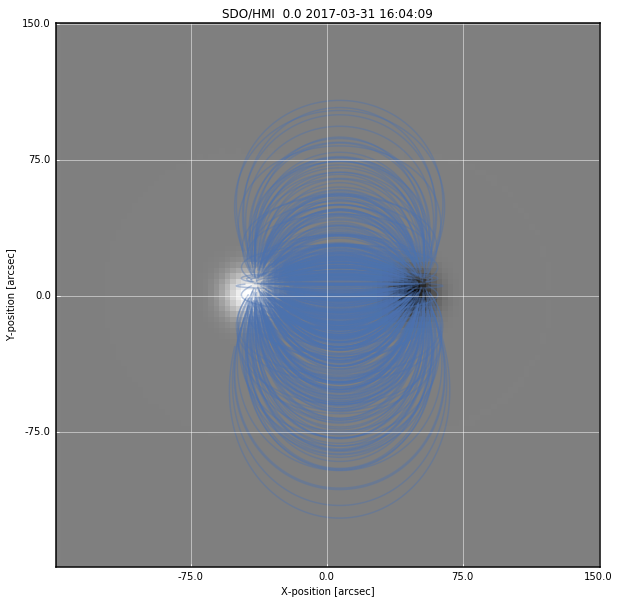

In [6]:
field.peek(alpha=0.4)

In [7]:
field.make_loops()

In [ ]:
p = yt.ProjectionPlot(field.extrapolated_3d_field,'z','Bz')
p.annotate_streamlines('Bx','By',density=1)
p.show()

## Subclassing EBTEL Interface

In [8]:
class EbtelSpatialVariations(EbtelInterface):
    
    def load_results(self, loop):
        # load results
        tmp = np.loadtxt(loop.hydro_configuration['output_filename'])
        time = tmp[:,0]*u.s
        temperature = tmp[:,1]*u.K
        density = tmp[:,3]*(u.cm**(-3))
        velocity = tmp[:,-2]*u.cm/u.s
        
        # calculate some constants
        c2 = 0.9
        c3 = 0.6
        h_to_he = loop.hydro_configuration['helium_to_hydrogen_ratio']
        z_avg = (1.0 + 2.0*h_to_he)/(1.0 + h_to_he)
        kB_correction = (1.0 + 1.0/z_avg)/2.0
        mi_correction = (1.0 + 4.0*h_to_he)/(2.0 + 3.0*h_to_he)*2.0*kB_correction
        mi = const.m_p.cgs*mi_correction
        g0 = sun_const.surface_gravity.cgs/u.s
        r0 = sun_const.radius.cgs
        
        # find apex, average, and TR points
        sparse_field_aligned_coordinate = np.array([loop.field_aligned_coordinate[0].value,
                                                    0.05*loop.full_length.value,
                                                    0.2*loop.full_length.value,
                                                    loop.field_aligned_coordinate[np.argmax(loop.coordinates[:,2])].value,
                                                    0.8*loop.full_length.value,
                                                    0.95*loop.full_length.value,
                                                    loop.field_aligned_coordinate[-1].value])
 
        # temperature
        temperature_0 = c3/c2*temperature
        temperature_a = temperature/c2
        temperature_chromosphere = 1e4*np.ones(temperature.shape)
        sparse_temperature = np.vstack((temperature_chromosphere,temperature_0,
                                        temperature,temperature_a,temperature,
                                        temperature_0,temperature_chromosphere)).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_temperature,kind=2,axis=1)
        temperature_interp = f(loop.field_aligned_coordinate)
        
        # velocity
        sparse_velocity = np.vstack((np.zeros(velocity.shape),velocity,velocity,
                                     np.zeros(velocity.shape),
                                    -velocity,-velocity,np.zeros(velocity.shape))).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_velocity,kind='cubic',axis=1)
        velocity_interp = f(loop.field_aligned_coordinate)
        
        scale_height = 2.*const.k_B.cgs*temperature_interp/mi/g0
        
        # density
        density_chromosphere = 1e11*np.ones(density.shape)
        integral_0 = (self._spatial_integral(sparse_field_aligned_coordinate[1],
                                             loop.coordinates[:,2].value + sun_const.radius.cgs.value,
                                             loop.field_aligned_coordinate.value,scale_height.value))
        density_0 = c2/c3*density*np.exp((r0.value**2)*integral_0)
        integral_a = (self._spatial_integral(sparse_field_aligned_coordinate[3],
                                             loop.coordinates[:,2].value + sun_const.radius.cgs.value,
                                             loop.field_aligned_coordinate.value,scale_height.value))
        density_a = c3*density_0*np.exp(-(r0.value**2)*integral_a)
        sparse_density = np.vstack((density_chromosphere,density_0,
                                    density,density_a,density,
                                    density_0,density_chromosphere)).T
        
        # interpolate
        f = interp1d(sparse_field_aligned_coordinate,sparse_density,kind=1,axis=1)
        density_interp = f(loop.field_aligned_coordinate)
        
        return time,temperature_interp*temperature.unit,density_interp*density.unit,velocity_interp*velocity.unit
        
        
    def _spatial_integral(self,s_bound,z,s,scale_height):
        i_range = np.where(s<=s_bound)[0]
        if s[i_range].shape[0] == 1:
            i_range = np.array([i_range[0],i_range[0]+1])
        dz_ds = np.gradient(z[i_range],np.gradient(s[i_range]))
        return np.trapz((z[i_range])**(-2)*dz_ds/scale_height[:,i_range],s[i_range],axis=1)
    

## Configure and Run Simulations

In [9]:
class NanoflareTrain(PowerLawScaledWaitingTimes):
        
    def _calculate_start_times(self,rates):
        scaling_constant = self._calculate_scaling_constant(rates)
        time_start_rise = np.empty([self.number_events])
        wait_time_sum = 0.0
        for i in range(self.number_events):
            wait_time_sum += ((rates[i]**(1.0/self.heating_options['waiting_time_scaling']))
                              / scaling_constant)
            time_start_rise[i] = i*self.heating_options['duration'] + wait_time_sum
        
        return time_start_rise

In [10]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'average_waiting_time':4800.0,
    'waiting_time_scaling':1.0
}

In [11]:
heating_model = NanoflareTrain(heating_options)

In [12]:
ih = synthesizAR.util.InputHandler(os.path.join('/home/wtb2/Documents/codes',
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['total_time'] = 10000.0
base_config['use_flux_limiting'] = True
base_config['heating']['background'] = 1e-6
base_config['heating']['partition'] = 1.0

In [13]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/data/datadrive2/ar_viz/test_spatial_variations_ebtel/hydro_config/',
                                 '/data/datadrive2/ar_viz/test_spatial_variations_ebtel/hydro_results/')

In [14]:
modified_ebtel_interface = EbtelSpatialVariations(base_config,heating_model,
                                                  '/data/datadrive2/ar_viz/test_spatial_variations_ebtel/hydro_config/',
                                                  '/data/datadrive2/ar_viz/test_spatial_variations_ebtel/hydro_results/')

In [15]:
field.configure_loop_simulations(modified_ebtel_interface)

Power-law constrainer reached max # of tries, using best guess with error = 0.001111341537214261
Power-law constrainer reached max # of tries, using best guess with error = 0.0011967080959069953
Power-law constrainer reached max # of tries, using best guess with error = 0.001213255964611415
Power-law constrainer reached max # of tries, using best guess with error = 0.0012618483491562138
Power-law constrainer reached max # of tries, using best guess with error = 0.0011233805779720107
Power-law constrainer reached max # of tries, using best guess with error = 0.0011075945178699032
Power-law constrainer reached max # of tries, using best guess with error = 0.001595828750685424
Power-law constrainer reached max # of tries, using best guess with error = 0.0012025238837307661
Power-law constrainer reached max # of tries, using best guess with error = 0.0010288495133963238
Power-law constrainer reached max # of tries, using best guess with error = 0.0012838355014928027
Power-law constrainer r

In [16]:
for loop in field.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [17]:
field.load_loop_simulations(modified_ebtel_interface)

## Plotting Examples

(10000000.0, 100000000000.0)

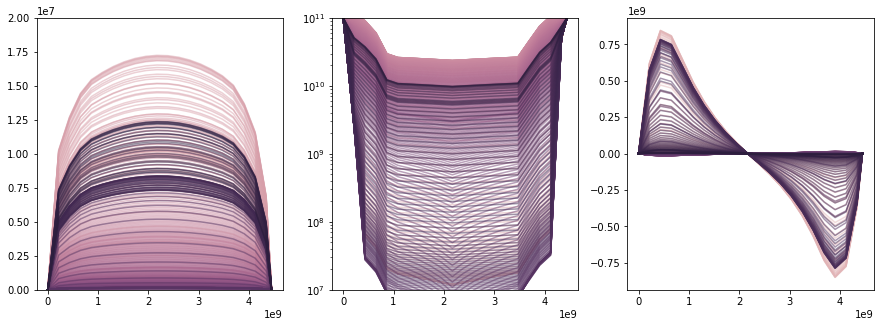

In [103]:
test_loop = field.loops[0]
fig,axes = plt.subplots(1,3,figsize=(15,5))
colors = sns.cubehelix_palette(test_loop.time.shape[0])
for t_index in test_loop.time:
    #print(t_index)
    i = np.where(test_loop.time==t_index)[0][0]
    axes[0].plot(test_loop.field_aligned_coordinate,
                 test_loop.temperature[i,:],
                 color=colors[i],alpha=0.5)
    axes[1].plot(test_loop.field_aligned_coordinate,
                 test_loop.density[i,:],
                 color=colors[i],alpha=0.5)
    axes[2].plot(test_loop.field_aligned_coordinate,
                 test_loop.velocity[i,:],
                 color=colors[i],alpha=0.5)
axes[0].set_ylim([9e3,2e7])
axes[1].set_yscale('log')
axes[1].set_ylim([1e7,1e11])
#axes[2].set_yscale('symlog')

(9000000.0, 100000000000.0)

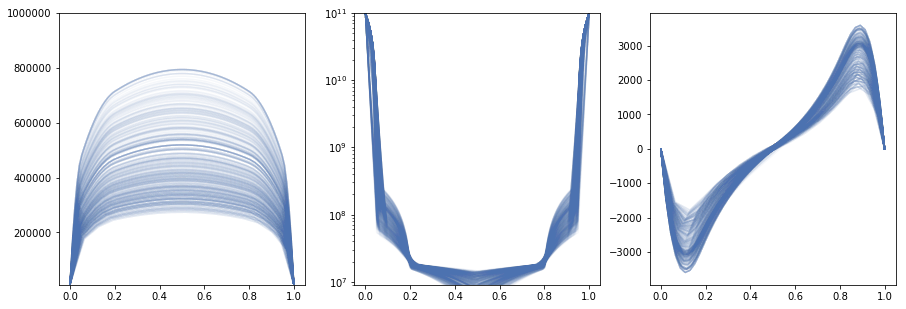

In [104]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for loop in field.loops:
    axes[0].plot(loop.field_aligned_coordinate/loop.full_length,
                 loop.temperature[0,:],
                 color=sns.color_palette('deep')[0],alpha=0.05)
    axes[1].plot(loop.field_aligned_coordinate/loop.full_length,
                 loop.density[0,:],
                 color=sns.color_palette('deep')[0],alpha=0.05)
    axes[2].plot(loop.field_aligned_coordinate/loop.full_length,
                 loop.velocity[0,:],
                 color=sns.color_palette('deep')[0],alpha=0.05)
axes[0].set_ylim([9e3,1e6])
axes[1].set_yscale('log')
axes[1].set_ylim([9e6,1e11])
#axes[2].set_yscale('symlog')

(0.0, 9999.556365641703)

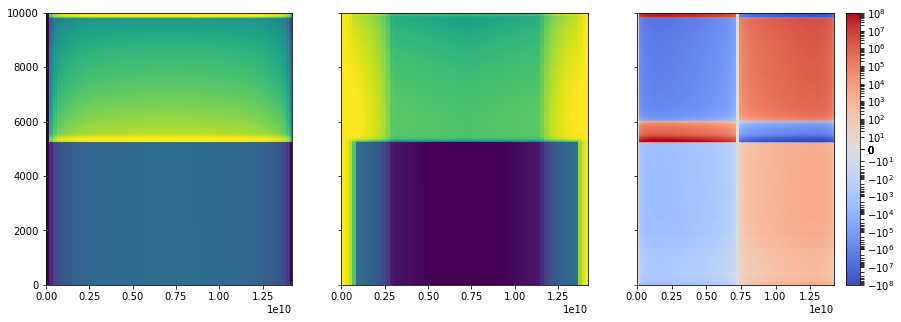

In [105]:
test_loop = field.loops[100]
smesh,tmesh = np.meshgrid(test_loop.field_aligned_coordinate,test_loop.time)
fig,axes = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
axes[0].pcolormesh(smesh.value,tmesh.value,test_loop.temperature.value,
                   norm=matplotlib.colors.LogNorm(1e5,2e7)
                  )
axes[1].pcolormesh(smesh.value,tmesh.value,test_loop.density.value,
                   norm=matplotlib.colors.LogNorm(1e7,1e11)
                  )
im = axes[2].pcolormesh(smesh.value,tmesh.value,test_loop.velocity.value,
                   cmap=matplotlib.colors.ListedColormap(sns.color_palette('coolwarm', n_colors=1000)),
                   norm=matplotlib.colors.SymLogNorm(10, vmin=-1e8, vmax=1e8)
                  )
plt.colorbar(im)
axes[0].set_xlim([test_loop.field_aligned_coordinate[0].value,
                  test_loop.field_aligned_coordinate[-1].value])
axes[1].set_ylim([test_loop.time[0].value,
                  test_loop.time[-1].value])

## AIA Emission

In [146]:
aia = InstrumentSDOAIA([5000,6000]*u.s)

In [147]:
observer = synthesizAR.Observer(field,instruments=[aia],
                                ds=field._convert_angle_to_length(0.4*u.arcsec))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


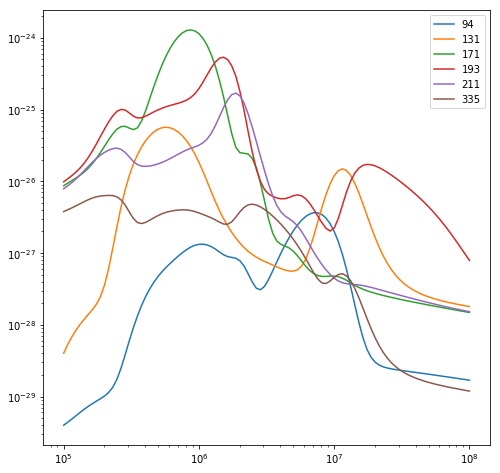

In [148]:
plt.figure(figsize=(8,8))
response_function_temperature = np.logspace(5,8,100)
for channel in aia.channels:
    plt.plot(response_function_temperature,
             splev(response_function_temperature,channel['temperature_response_spline']),
             label=channel['name'])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

In [149]:
observer.build_detector_files('/data/datadrive2/ar_viz/test_spatial_variations_ebtel/')

In [150]:
observer.flatten_detector_counts()

## Visualizing Thermodynamic Quantities

In [163]:
vel_map = observer.make_los_velocity_map(5.5e3*u.s,aia)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


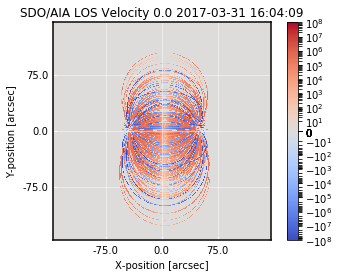

In [164]:
vel_map.peek()

In [ ]:
temperature_map = observer.make_temperature_map(5.5e3*u.s,aia)

In [ ]:
temperature_map.peek()

In [152]:
em_cube = observer.make_emission_measure_map(5.5e3*u.s,aia,temperature_bin_edges=10.**(np.arange(5,7.3,0.2))*u.K)

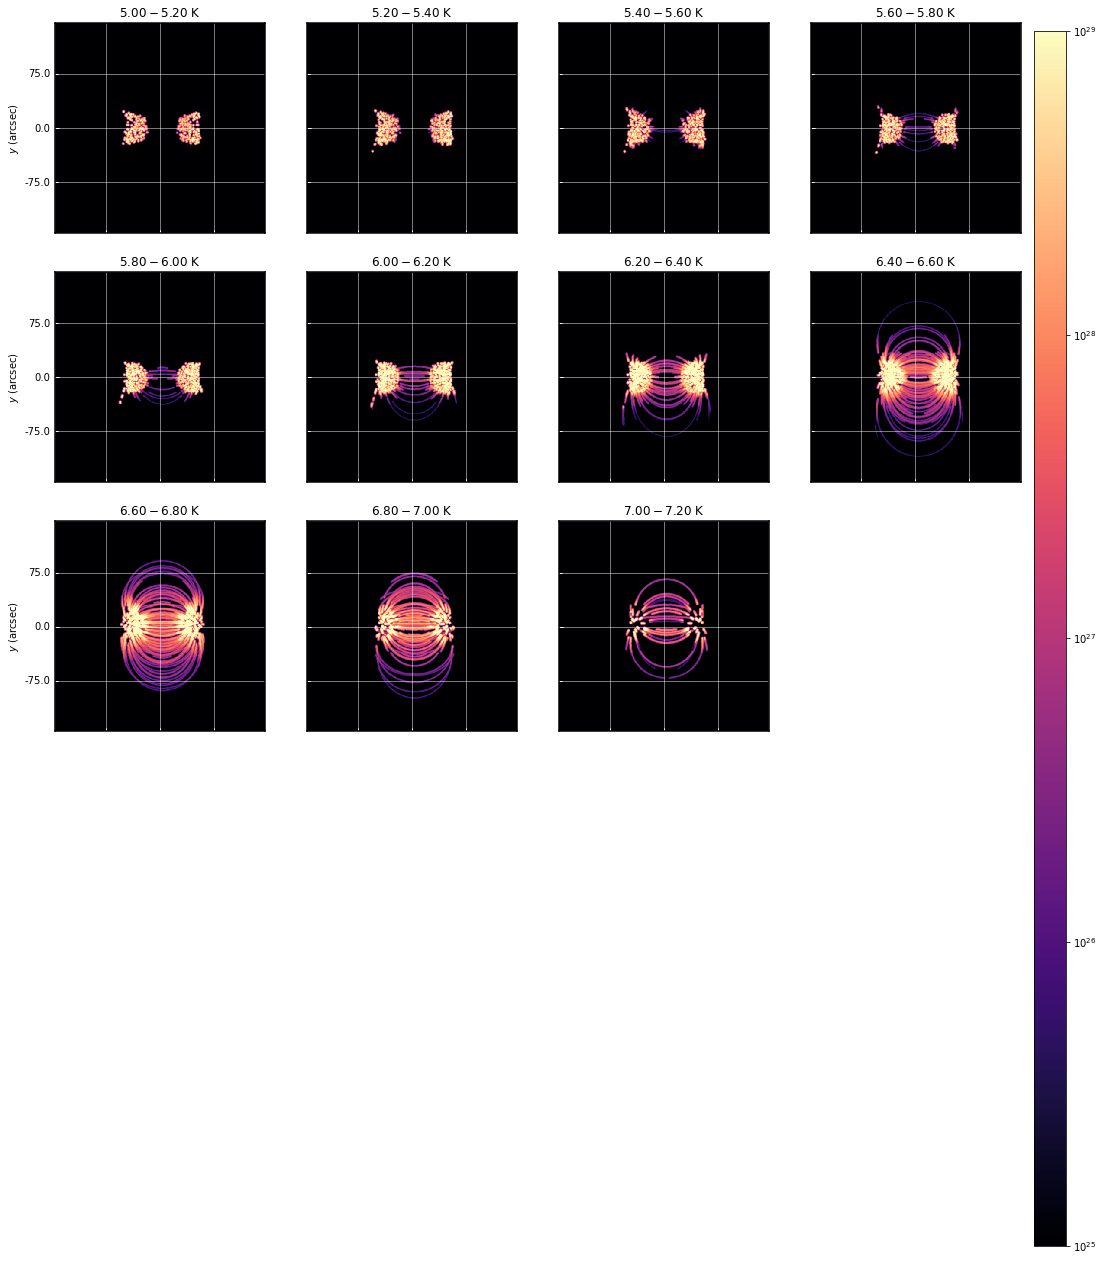

In [153]:
fig = plt.figure(figsize=(18,22.5))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = em_cube[i]#.submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[1]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(5,4,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1, vmin=1e25, vmax=1e29)
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<16:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%4==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
pow_ticks = [25,26,27,28,29]
cbar = fig.colorbar(im, ticks=10.**np.array(pow_ticks),cax=cax,format=LogFormatter(10,labelOnlyBase=False))
cbar.set_ticklabels([r'$10^{{{}}}$'.format(t) for t in pow_ticks])
#fig.suptitle(r'Emission Measure, $\mathrm{EM}(T)$ ($\mathrm{cm}^{-5}$)')

Finally, bin the detector counts into a Map at each timestep

In [ ]:
observer.bin_detector_counts('/data/datadrive2/ar_viz/test_spatial_variations_ebtel/')

## Organizing Data with `yt`
Test a model where we pull everything into a `yt` dataset.

In [154]:
# bin densities and temperatures
i_time = np.where(aia.observing_time==5.5e3*u.s)[0][0]
with h5py.File(aia.counts_file,'r') as hf:
    unbinned_temperature = np.array(hf['average_temperature'][i_time,:])
    temperature_unit = u.Unit(hf['average_temperature'].attrs['units'])
    unbinned_density = np.array(hf['average_density'][i_time,:])
    density_unit = u.Unit(hf['average_density'].attrs['units'])

In [155]:
min_z = field.extrapolated_3d_field.domain_left_edge[2]*u.cm
max_z = np.max(observer.total_coordinates[:,2])*1.1
bins_z = int(np.ceil((max_z - min_z)/field._convert_angle_to_length(aia.resolution.x*1.*u.pixel)))

In [156]:
loop_cell_volume = (field._convert_angle_to_length(0.4*u.arcsec))**3
grid_cell_volume = (field._convert_angle_to_length(aia.resolution.x*1.*u.pixel)
                    *field._convert_angle_to_length(aia.resolution.y*1.*u.pixel)
                    *field._convert_angle_to_length(aia.resolution.x*1.*u.pixel))

In [157]:
coordinate_hist,_ = np.histogramdd(observer.total_coordinates.value,
                                 bins=[aia.bins.x,aia.bins.y,bins_z],
                                 range=[aia.bin_range.x,aia.bin_range.y,[min_z.value,max_z.value]])
temp_hist,_ = np.histogramdd(observer.total_coordinates.value,
                           bins=[aia.bins.x,aia.bins.y,bins_z],
                           range=[aia.bin_range.x,aia.bin_range.y,[min_z.value,max_z.value]],
                           weights=unbinned_temperature)
temp_hist /= np.where(coordinate_hist==0.0,1.,coordinate_hist)
density_hist,_ = np.histogramdd(observer.total_coordinates.value,
                               bins=[aia.bins.x,aia.bins.y,bins_z],
                               range=[aia.bin_range.x,aia.bin_range.y,[min_z.value,max_z.value]],
                               weights=unbinned_density*loop_cell_volume/grid_cell_volume
                               )

In [158]:
data_dict = dict(
    T=(temp_hist,'K'),
    n=(density_hist,'cm**(-3)')
)
bbox = np.array([[left,right] for left,right in zip(field.extrapolated_3d_field.domain_left_edge.value,
                                                    field.extrapolated_3d_field.domain_right_edge.value)])
bbox[2,1] = max_z.value

In [159]:
test_yt_ds = yt.load_uniform_grid(data_dict,data_dict['T'][0].shape,
                                  bbox=bbox,length_unit=yt.units.cm,
                                  geometry=('cartesian',('x','y','z')))

yt : [INFO     ] 2017-05-19 14:46:04,191 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-19 14:46:04,194 Parameters: domain_dimensions         = [485 485 221]
yt : [INFO     ] 2017-05-19 14:46:04,196 Parameters: domain_left_edge          = [ -1.02667285e+10  -1.02667285e+10   4.33805429e+08]
yt : [INFO     ] 2017-05-19 14:46:04,197 Parameters: domain_right_edge         = [  1.07728348e+10   1.07728348e+10   9.99092025e+09]
yt : [INFO     ] 2017-05-19 14:46:04,198 Parameters: cosmological_simulation   = 0.0


In [160]:
@yt.derived_field(name='emission_measure',units='cm**(-6)')
def _emission_measure(field,data):
    return data['n']*data['n']

yt : [WARNING  ] 2017-05-19 14:46:06,122 Field ('gas', 'emission_measure') already exists. To override use force_override=True.


In [161]:
test_yt_ds.add_field('emission_measure',function=_emission_measure,units='cm**(-6)')

yt : [INFO     ] 2017-05-19 14:46:37,193 Projection completed
yt : [INFO     ] 2017-05-19 14:46:37,194 xlim = -10266728496.855629 10772834831.132027
yt : [INFO     ] 2017-05-19 14:46:37,195 ylim = 433805429.443045 9990920250.063524
yt : [INFO     ] 2017-05-19 14:46:37,198 xlim = -10266728496.855629 10772834831.132027
yt : [INFO     ] 2017-05-19 14:46:37,200 ylim = 433805429.443045 9990920250.063524
yt : [INFO     ] 2017-05-19 14:46:37,202 Making a fixed resolution buffer of (('gas', 'emission_measure')) 800 by 800



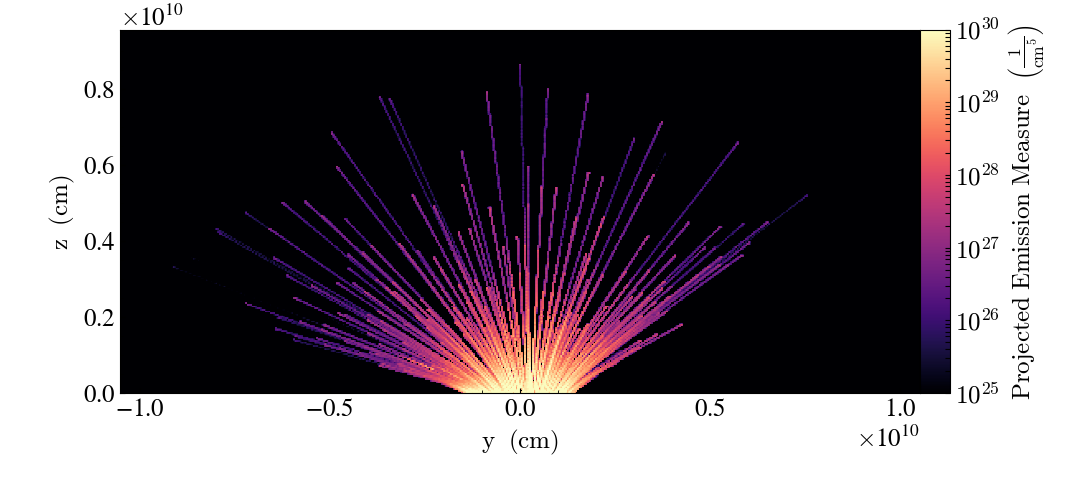

In [162]:
p = yt.ProjectionPlot(test_yt_ds,'x','emission_measure',origin='lower-center-domain',axes_unit='cm')
custom_map = plt.get_cmap('magma')
custom_map.set_bad(color=custom_map.colors[0])
p.set_cmap('emission_measure',custom_map)
p.set_zlim('emission_measure',1e25,1e30,)
#p.zoom(10)
p.show()

## Visualizing Observable Quantities

In [ ]:
map_template = '/data/datadrive2/ar_viz/test_spatial_variations_ebtel/SDO_AIA/{channel}/map_t{ti:06d}.fits'

In [ ]:
fig = plt.figure(figsize=(18,12))
ti = np.where(aia.observing_time==aia.observing_time[10])[0][0]
fig.suptitle(r'$t = {}$ {}'.format(aia.observing_time[ti].value,aia.observing_time.unit))
for i,channel in enumerate(aia.channels):
    tmp_map = sunpy.map.Map(map_template.format(channel=channel['name'],ti=ti))
    ax = fig.add_subplot(2,3,i+1,projection=tmp_map)
    tmp_map.plot(axes=ax,
                 norm=matplotlib.colors.SymLogNorm(1,vmin=1e2,vmax=1e6),
                 annotate=False)
    x_world_text = -125.0*u.arcsecond
    y_world_text = 80.0*u.arcsecond
    x_pixel,y_pixel = tmp_map.data_to_pixel(x_world_text,y_world_text)
    ax.text(x_pixel.value,y_pixel.value,r'${}$ $\mathrm{{\AA}}$'.format(channel['name']),
            fontsize=18,color='w')
    if i < 3:
        ax.coords[0].set_ticklabel_visible(False)
        ax.coords[0].set_ticks_visible(False)
    else:
        ax.coords[0].set_axislabel(r'$x$ $(\mathrm{{{uni}}})$'.format(uni=tmp_map.center.x.unit),fontsize=15)
        ax.coords[0].set_ticklabel(fontsize=12)
    if i % 3 != 0:
        ax.coords[1].set_ticklabel_visible(False)
        ax.coords[1].set_ticks_visible(False)
    else:
        ax.coords[1].set_axislabel(r'$y$ $(\mathrm{{{uni}}})$'.format(uni=tmp_map.center.y.unit),fontsize=15)
        ax.coords[1].set_ticklabel(fontsize=12)

In [ ]:
foo = sunpy.map.Map(map_template.format(channel=171,ti=0))

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
(foo
.submap(u.Quantity([-75*u.arcsec,0*u.arcsec]),
        u.Quantity([-35*u.arcsec,35*u.arcsec]))
.plot(norm=matplotlib.colors.SymLogNorm(1,vmin=10,vmax=1e6),axes=ax))

In [ ]:
foo.data_to_pixel(0*u.arcsec,0*u.arcsec)

In [ ]:
plt.figure(figsize=(8,8))
for channel in aia.channels:
    foo = sunpy.map.Map(map_template.format(channel=channel['name'],ti=0))
    plt.plot(foo.data[241,:],label=channel['name'])
plt.legend(loc='best')
plt.yscale('log')
plt.ylim([10,1e6])
plt.xlim([0,foo.data.shape[1]])